## Imports

In [92]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import plotly.offline as py
py.init_notebook_mode(connected=True)
from matplotlib_venn import venn2
import plotly.graph_objs as go

In [2]:
data = pd.read_excel('Real Estate/US Real Estate Pricing data.xlsx')

In [3]:
data.shape

(39030, 80)

In [ ]:
#data.info()

# Missing Values

### 59 columns with missing values

### Analysing the data we see Block ID has no values so we can drop the column al together

In [ ]:
## remove Block ID as no value present

In [4]:
data.drop('BLOCKID',inplace = True,axis = 1)

# drop the rows where response variable is missing

In [5]:
data = data[pd.notnull(data['hc_mortgage_mean'])]

In [6]:
mising_value_data = data.isnull().sum()

In [7]:
missing_data_column = mising_value_data[mising_value_data>0].index

In [9]:
missing_data_column

Index(['rent_mean', 'rent_median', 'rent_stdev', 'rent_sample_weight',
       'rent_samples', 'rent_gt_10', 'rent_gt_15', 'rent_gt_20', 'rent_gt_25',
       'rent_gt_30', 'rent_gt_35', 'rent_gt_40', 'rent_gt_50', 'family_mean',
       'family_median', 'family_stdev', 'family_sample_weight',
       'family_samples', 'hc_mean', 'hc_median', 'hc_stdev', 'hc_samples',
       'hc_sample_weight', 'hs_degree_male', 'hs_degree_female',
       'male_age_mean', 'male_age_median', 'male_age_stdev',
       'male_age_sample_weight', 'male_age_samples', 'female_age_mean',
       'female_age_median', 'female_age_stdev', 'female_age_sample_weight',
       'female_age_samples', 'married', 'married_snp', 'separated',
       'divorced'],
      dtype='object')

In [ ]:
# imputing missing values for rest of the varaibles using mena of state and city 
# for examplefor hc_mean

In [ ]:
import time

In [ ]:
time.time()

In [ ]:
#start = time.time()
for j in missing_data_column:
    print ('variable = ', j)
    k = 1
    for i in data.city.unique():
        print("city", k)
        k += 1
        data.loc[(data[j].isnull()) & (data.city == i),j] = data.groupby('city')[j].median()[i]
#end = time.time()

In [10]:
for j in missing_data_column:
    data.loc[(data[j].isnull()),j] = data[j].median()

## Explore the top 2,500 locations where the percentage of households with a second mortgage is the highest and percent ownership is above 10%. Visualize using geo-map. You may keep the upper limit for the percent of households with a second mortgage to roughly 50%.

In [12]:
term = 'second_mortgage'
places = []

# ownership is above 10%
## need lat lng and place for the geo map
df_pop = data[data['pct_own']> .1]
df_pop=df_pop[[term,'place','lat','lng','pct_own','pop']]
df_pop.sort_values(by=term, ascending=False,inplace = True)

## text in the map
df_pop['text'] = df_pop.place + 'Second Mortgage ' + round(df_pop[term]*100,4).astype(str) + '%'

layout = dict(title = 'Top 2500 Highest Second Mortgage Locations', showlegend = True,geo = dict(
         scope='usa', projection=dict( type='albers usa' ),showland = True,landcolor = 'rgb(217, 217, 217)',
         subunitwidth=1,countrywidth=1, subunitcolor="rgb(255, 255, 255)", countrycolor="rgb(255, 255, 255)"))

## limits is locations ranks 
limits = [(0,499),(500,999),(1000,1499),(1500,1999),(2000,2500)]
colors = ["rgb(0,116,217)","rgb(255,65,54)","rgb(133,20,75)","rgb(255,133,27)","rgb(76, 199, 144)"]
scale = 1000
# create colors for plot
for i in range(len(limits)): 
    nme = '{0} - {1}'.format(limits[i][0],limits[i][1])
    #print('name = ', nme)
    df_sub = df_pop[limits[i][0]:limits[i][1]]
    places.append(dict(type = 'scattergeo', 
                       locationmode = 'USA-states', 
                       lon = df_sub.lng, 
                       lat = df_sub.lat, 
                       text = df_sub.text,
                       marker = dict(color = colors[i],
                                     size = list(map(lambda x: 15 + x*scale,df_sub[term].values)),
                                     line = dict(width=0.5, color='rgb(40,40,40)'), 
                                     sizemode = 'area'), 
                       name = nme))
    


fig = dict( data=places, layout=layout )

py.iplot( fig, 
         validate=False, 
         filename='d3-mortgage',
         show_link=False,
         config={'displayModeBar':False,'showLink': False})

Bad debt is the debt you should avoid at all costs such as a second mortgage or home equity loan. Conversely, Good debt is all other debt not including second mortgage or home equity loan.

In [13]:
## calculate Bad debt and good debt
data['bad_debt'] = data['second_mortgage']+data['home_equity'] - data['home_equity_second_mortgage']
data['good_debt'] = data['debt'] - data['bad_debt']

In [14]:
## calculate nodebt = 1- debt
data['no_debt'] = 1 - data['debt']

In [15]:
mean_vals = data.mean(axis=0)

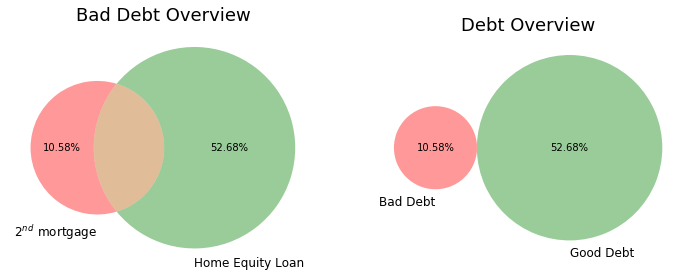

In [17]:
# Bad Debt Overview Ven Diagram:
## subplots
fig, ax = plt.subplots(1,2, figsize=(12, 6))
label = ['2$^n$$^d$ mortgage','Home Equity Loan']
flds = ['second_mortgage','home_equity','home_equity_second_mortgage']
term = ['10','01','11'];

# create plots
out  = venn2(subsets=(mean_vals[flds[0]],mean_vals[flds[1]],mean_vals[flds[2]]),
             set_labels=(label[0],label[1]),
             ax=ax[0])
out1 = venn2(subsets = (mean_vals['bad_debt'], mean_vals['good_debt'],.00001), 
             set_labels = ('Bad Debt', 'Good Debt'), 
             ax=ax[1])
## setting the outputs
out1.get_label_by_id('10').set_text(str(round(100*mean_vals['bad_debt'],2)) + '%')
out1.get_label_by_id('01').set_text(str(round(100*mean_vals['good_debt'],2)) + '%')
out1.get_label_by_id('11').set_text(' ')

out.get_label_by_id('10').set_text(str(round(100*mean_vals['bad_debt'],2)) + '%')
out.get_label_by_id('01').set_text(str(round(100*mean_vals['good_debt'],2)) + '%')
out.get_label_by_id('11').set_text(' ')

# title and plot data:
ax[1].title.set_text("Debt Overview"); 
ax[0].title.set_text("Bad Debt Overview"); 
ax[0].title.set_fontsize(18); ax[0].title.set_fontsize(18);
ax[1].title.set_fontsize(18); ax[1].title.set_fontsize(18);
plt.show()

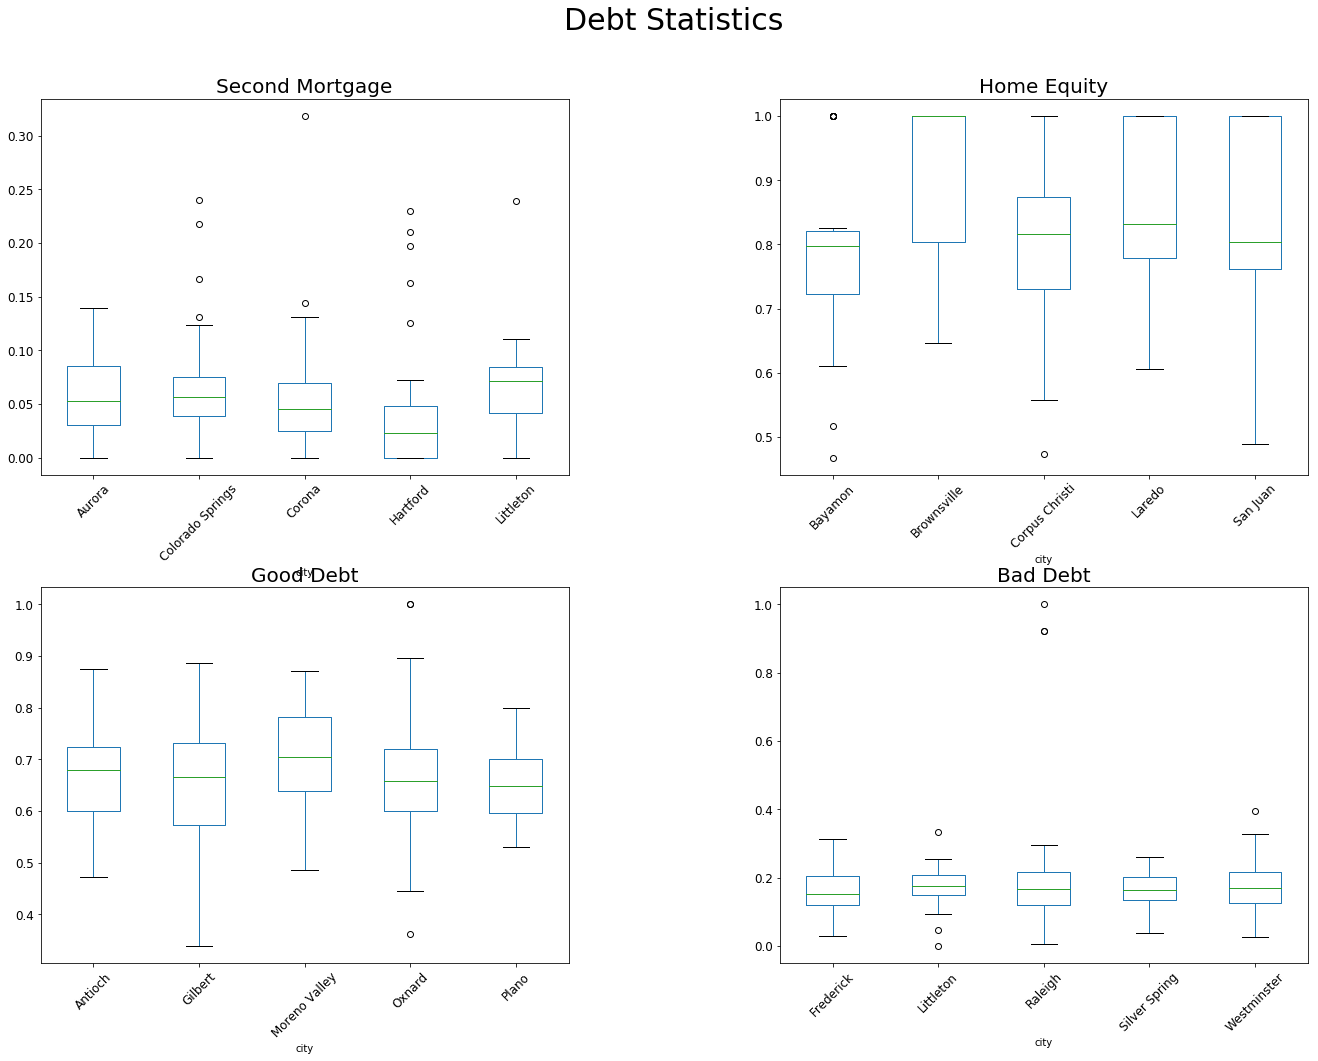

In [18]:
## data to plot
city_count = data.city.value_counts()
bad_cities = city_count[city_count.values < 25].index.tolist()

flds  = ['city','second_mortgage','home_equity_cdf','bad_debt','good_debt','pop']
fldp = ['second_mortgage','home_equity_cdf','good_debt','bad_debt']; 

# group data & filter data
df_city = data[data['pct_own']> .1][flds].groupby(['city']).mean().dropna()
df_city = df_city[~df_city.index.isin(bad_cities)]
f,ax = plt.subplots(2,2,figsize=(22,16))

title=[['Second Mortgage' , 'Home Equity'],['Good Debt','Bad Debt']]
j = 0;k=0
for i in fldp:
    gg = df_city.sort_values(i,ascending=0).index.tolist()[:5]
    dt_sub = data.loc[data.city.isin(gg),[i,'city']]
    dt_sub.boxplot(i,'city',fontsize=12, rot=45,ax = ax[j,k],grid = False)
    ax[j,k].set_title(title[j][k], fontsize= 20)
    k +=1
    if k == 2 :
        j +=1
        k  =0
f.suptitle('Debt Statistics',fontsize = 30)    
plt.subplots_adjust(wspace=0.4,hspace=0.3)

## Create a collated income distribution chart for family income, house hold income and remaining income. 

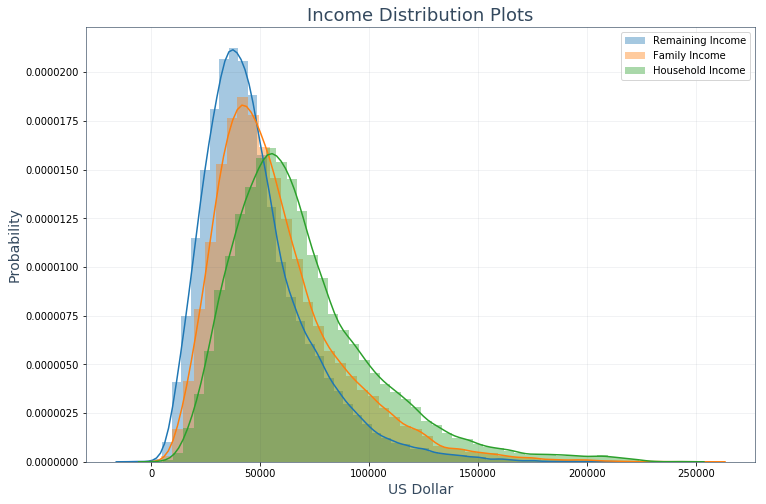

In [19]:
# break down the three categories into basic equations
noDebt   = data.no_debt.values*data.hc_mean.values;
goodDebt = data.good_debt.values*data.hc_mortgage_median.values;
badDebt  = data.bad_debt.values*data.hc_mortgage_median.values; # +df['hc_mortgage_stdev'].values);

# hc_feature: housing cost feature
data['hc_feature'] = goodDebt + noDebt + badDebt


import numpy as np

# adjust from one month to one year:
home_costs =  np.asarray(list(map(lambda x: 12*x ,data.hc_feature)))
rent_costs =  np.asarray(list(map(lambda x: 12*x ,data.rent_median)))

# calculate rent and home adjusted income                              
rent_adj_inc = data.family_median.values - rent_costs; # adj family income                       
home_adj_inc = data.hi_median.values - home_costs; # adj household income                    
pct_own  = data.pct_own.values; # percent own                          
pct_rent = np.asarray(list(map(lambda x: 1-x,data.pct_own))); # percent rent   

# save remaining income and remaining costs
data['rem_income'] = (pct_own*home_adj_inc) + (pct_rent*rent_adj_inc); # remaining income 
data['rem_costs']  = (pct_own*home_costs) + (pct_rent*rent_costs);     # remaining costs 


import seaborn as sns

# fields to create plots
flds = ['family_median','rem_income','type','hi_median','rent_median'];

# plot expendable_income & discounted_income
f, ax = plt.subplots(figsize=(12,8))
plt_df = data.dropna(subset=['rem_income'])[flds];
sns.distplot(plt_df.rem_income,bins=50)
sns.distplot(plt_df.hi_median,bins=50)
sns.distplot(plt_df.family_median,bins=50)
plt.legend(['Remaining Income','Family Income','Household Income'])

# plot a bubble in the senter
plt.xlabel("US Dollar", fontsize=14,color = '#34495E'); 
plt.ylabel("Probability", fontsize=14,color = '#34495E')
plt.title('Income Distribution Plots', fontsize=18,color = '#34495E')
plt.setp(ax.spines.values(), color='#34495E',alpha = .8)
ax.grid(color = '#2C3E50',alpha = .08)
ax.patch.set_alpha(0)
plt.grid(True)
plt.show()

Perform EDA and come out with insights into population density and age. You may require deriving new fields (Make sure to weight averages for accurate measurements): 

* Population density (hint-use ‘pop’ and ‘Aland’ to calculate)
* median age (hint-use the variables ‘male_age_median’, ‘female_age_median’, ‘male_pop’, ‘female_pop’)
Visualize the findings using appropriate chart type.


In [20]:
data['pop_density'] = data['pop']/data['ALand']

In [21]:
# calculate average median age
t_male_yrs       = data.male_age_median.values*data.male_pop.values
t_female_yrs     = data.female_age_median.values*data.female_pop.values 
data['age_median'] = (t_male_yrs + t_female_yrs)/(data.male_pop.values + data.female_pop.values)

## Create bins for population into a new variable by selecting appropriate class interval so that the no of categories(bins) don’t exceed 5 for the ease of analysis. Analyze the married, separated and divorced population for these population brackets. Visualize using appropriate chart type.

In [22]:
## create pop bucket  
## understand the pop distribution

In [24]:
data['pop'].describe()

count    38189.000000
mean      4378.018147
std       2084.812356
min          4.000000
25%       2949.000000
50%       4100.000000
75%       5463.000000
max      53812.000000
Name: pop, dtype: float64

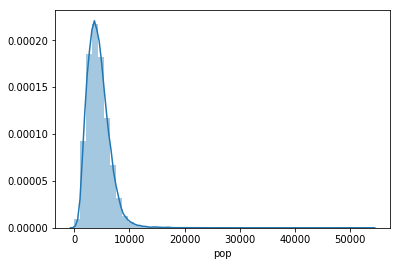

In [25]:
sns.distplot(data['pop'])

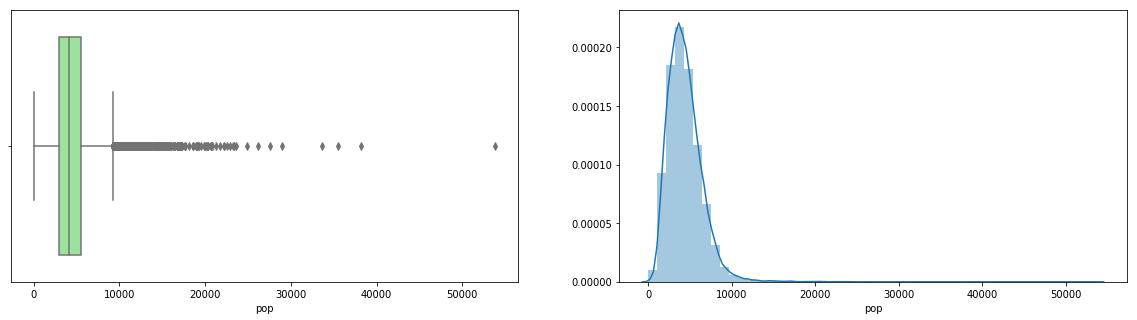

In [29]:
f,ax=plt.subplots(1,2,figsize=(20,5))
sns.boxplot('pop',data= data,color = 'lightgreen',ax = ax[0])
sns.distplot(data['pop'], ax = ax[1])
plt.show()

In [38]:
def func(x):
    if x <3500:
        return 'upto 3500'
    elif x < 7000:
        return '3500 to 7000'
    elif x < 10500:
        return '7000 to 10500'
    elif x < 30000:
        return '10500 to 30000'
    else :
        return '30000 and above'

In [43]:
data['pop_class'] = data['pop'].apply(func)

In [44]:
data['pop_married'] = data['married']*data['pop']
data['pop_divorced'] = data['divorced']*data['pop']
data['pop_separated'] = data['separated']*data['pop']

In [73]:
pop_sum = data[['pop_class','pop_married','pop','pop_divorced','married']].groupby('pop_class').mean()['pop_married']
pop_sum

pop_class
10500 to 30000      7868.095656
30000 and above    29458.587403
3500 to 7000        2567.106660
7000 to 10500       4412.836823
upto 3500           1231.389502
Name: pop_married, dtype: float64

In [74]:
data['pct_married_'] = data['pop_married']/ pop_sum.loc[data['pop_class']].values[0]

In [76]:
data['pct_married_'] = data['pop_married']/ pop_sum.loc[data['pop_class']].values[0]
data['pct_divorced_'] = data['pop_divorced']/ pop_sum.loc[data['pop_class']].values[0]
data['pct_separated_'] = data['pop_separated']/ pop_sum.loc[data['pop_class']].values[0]

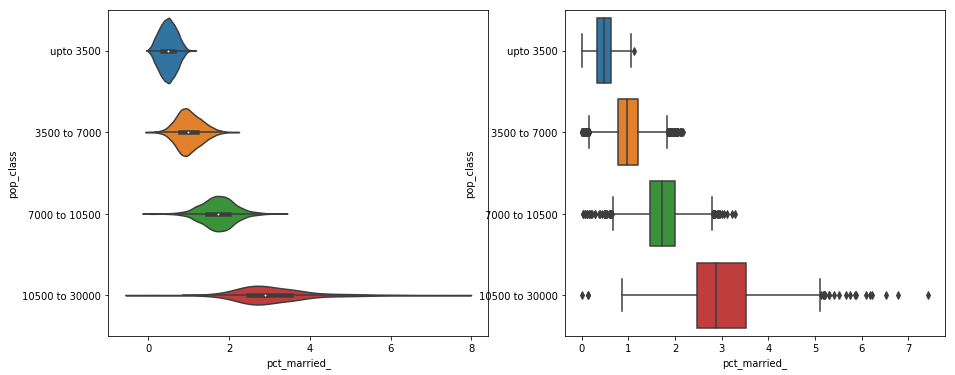

In [78]:
f,ax = plt.subplots(1,2,figsize =(15,6))
sns.violinplot(y ='pop_class',x= "pct_married_", data=data, split = True,
            order=['upto 3500','3500 to 7000','7000 to 10500','10500 to 30000'],ax= ax[0])

sns.boxplot(x = "pct_married_", y = 'pop_class', data=data, 
            order=['upto 3500','3500 to 7000','7000 to 10500','10500 to 30000'],ax=ax[1])

## Please detail your observations for rent as a percentage of income at an overall level and for different states.

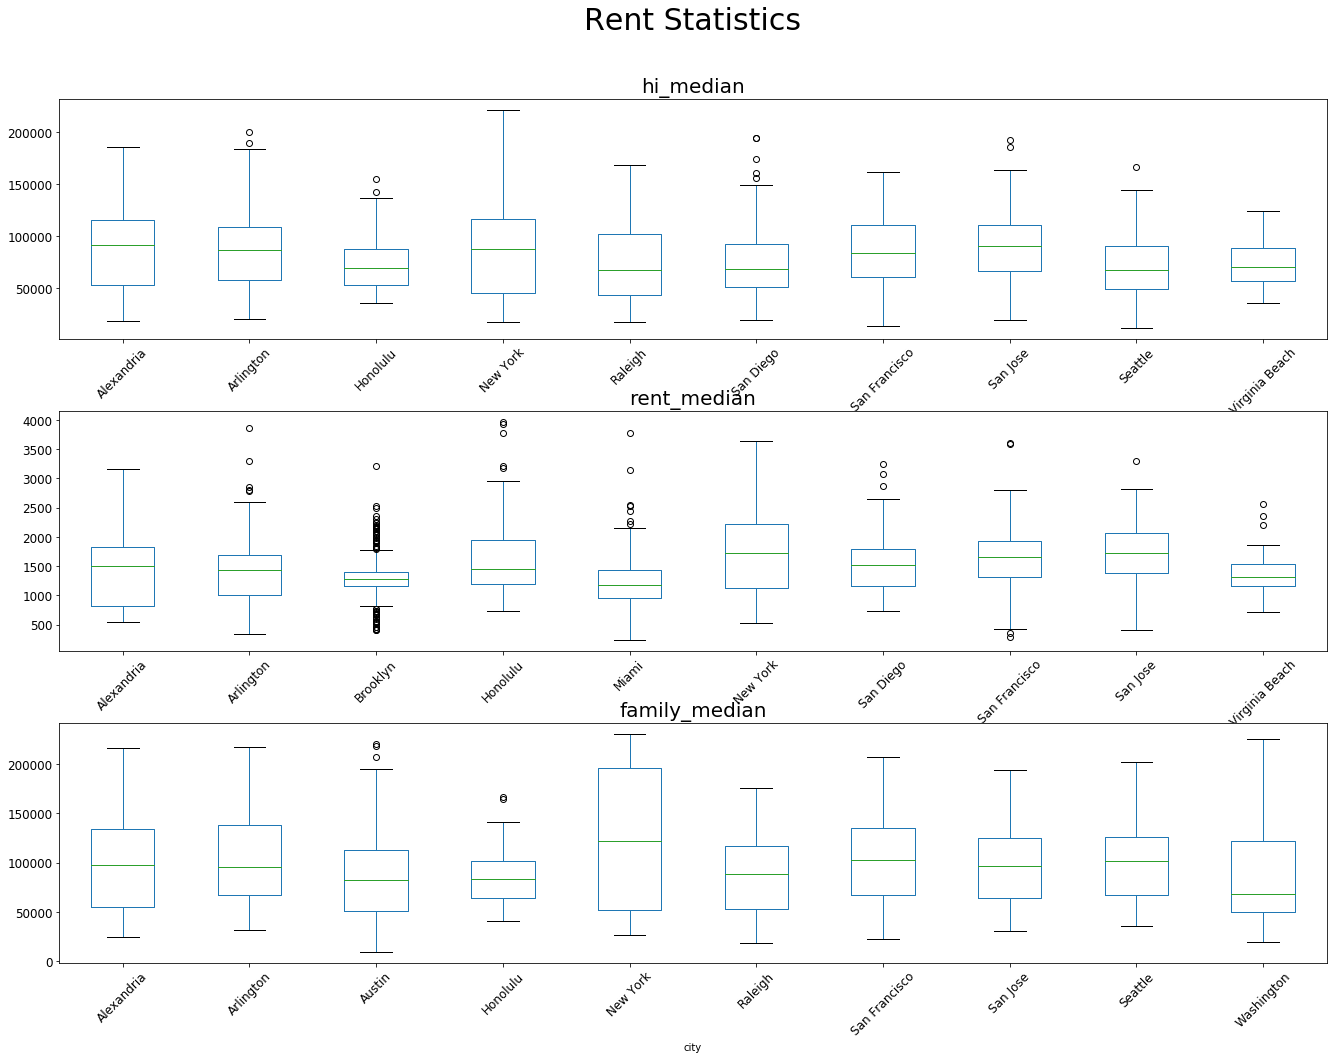

In [79]:
# Graphic Top Income Cities with a Population above 50 records

# data we wish to analize:
flds  = ['city','hi_median','family_median','rent_median','pop']
fldp  = ['hi_median','rent_median','family_median']

# will be used for new plots
city_count = data.city.value_counts()
bad_cities = city_count[city_count.values < 50].index.tolist()

# group data & filter data
df_city = data[flds].groupby(['city']).mean().dropna()
df_city = df_city[~df_city.index.isin(bad_cities)]


f,ax = plt.subplots(3,1,figsize=(22,16))
f.suptitle('Debt ')
j = 0;k=0
for i,j in zip(fldp,range(len(fldp))):
    gg = df_city.sort_values(i,ascending=0).index.tolist()[:10]
    dt_sub = data.loc[data.city.isin(gg),[i,'city']]
    dt_sub.boxplot(i,'city',fontsize=12, rot=45,ax = ax[j],grid = False)
    ax[j].set_title(i, fontsize= 20)
f.suptitle('Rent Statistics',fontsize = 30)    
plt.subplots_adjust(wspace=0.4,hspace=0.3)

## Perform correlation analysis for all the relevant variables by creating a heatmap. Describe your findings. 

In [80]:
data.isna().any()

UID                         False
SUMLEVEL                    False
COUNTYID                    False
STATEID                     False
state                       False
state_ab                    False
city                        False
place                       False
type                        False
primary                     False
zip_code                    False
area_code                   False
lat                         False
lng                         False
ALand                       False
AWater                      False
pop                         False
male_pop                    False
female_pop                  False
rent_mean                   False
rent_median                 False
rent_stdev                  False
rent_sample_weight          False
rent_samples                False
rent_gt_10                  False
rent_gt_15                  False
rent_gt_20                  False
rent_gt_25                  False
rent_gt_30                  False
rent_gt_35    

In [85]:
data_corr = data[['rent_gt_10', 'rent_gt_15', 'rent_gt_20', 'rent_gt_25', 'rent_gt_30', 'rent_gt_35', 'rent_gt_50', 
                  'family_median', 'hc_mortgage_median', 'hc_median', 'rent_median', 'rem_income','rem_costs', 
                  'pop_density', 'married', 'married_snp','hs_degree','hs_degree_male','hs_degree_female',
                  'female_age_median','male_age_mean','pop_density','married','married_snp','pct_own','second_mortgage',
                  'home_equity']]

In [86]:
corrmat = data_corr.corr()

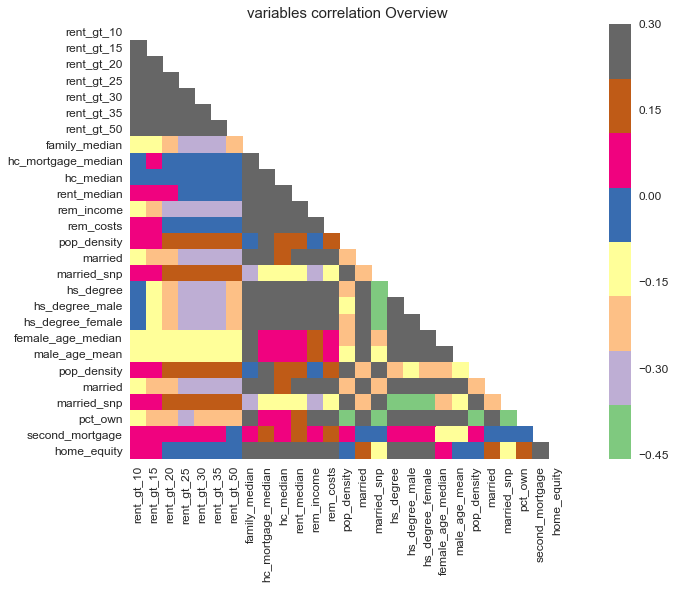

In [87]:
f = plt.figure(figsize=(16, 8))
sns.set(font_scale= 1.2,rc={"font.size": 2.1})
mask = np.zeros_like(corrmat); mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"): 
    ax = sns.heatmap(corrmat, mask=mask, vmax=.3, square=True, cmap = 'Accent')
plt.title("variables correlation Overview", fontsize=15); plt.show()

The economic multivariate data has a significant number of measured variables. The goal is to find where the measured variables depend on a number of smaller unobserved common factors or latent variables. Each variable is assumed to depend on a linear combination of the common factors, and the coefficients are known as loadings. Each measured variable also includes a component due to independent random variability, known as "specific variance" because it is specific to one variable. Obtain the common factors and then plot the loadings. Use factor analysis to find latent variables in our dataset and gain insight into the linear relationships in the data
1.	Highschool graduation rates
2.	Median population age
3.	Second Mortgage Statistics
4.	Percent Own
5.	Bad Debt Expense


In [88]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as sklearnPCA

In [89]:
data_var = ['hs_degree','age_median','second_mortgage','pct_own','bad_debt']

#standardize data
data_std = StandardScaler().fit_transform(data[data_var])

# Factor Analysis
pca = PCA(n_components=2)
factors = pca.fit_transform(data_std)

loadings = pca.components_

In [91]:
# look up dictionary for display names
flds = {'hs_degree':'Degree','age_median':'Age','second_mortgage':'2<sup>ed</sup> mortgage',
        'home_equity':'home equity','pct_own':'% Own','debt':'Debt','bad_debt':'Bad debt',
        'rem_costs':'Costs','rem_income':'Income','good_debt':'Good Debt',
       'married':'Married','divorced':'Divorced','separated':'Separated',
       'married_snp':'Spouse not present'};




# Plot constants
C1 = 'rgba(44, 62, 80, 1)'; C2 = 'rgba(44, 62, 80, .2)'
MAX = 300; trace = []; shapes = [];

# create original shape
shapes.append({'type': 'circle','layer':'below','xref': 'x','yref': 'y',
'x0': -1,'y0': -1,'x1': 1,'y1': 1,'fillcolor': 'rgba(44, 62, 80, .35)',
'line': {'color': 'rgba(0, 0, 0,0)'}})

for i in range(MAX):
    shapes.append({'type': 'circle','layer':'below','xref': 'x','yref': 'y',
                   'x0': -i**3/MAX**3,'y0': -i**3/MAX**3,'x1': i**3/MAX**3,
                   'y1': i**3/MAX**3,'fillcolor': 'rgba(250,250,250, .1)',
                   'line': {'color': 'rgba(0, 0, 0,0)'}})



for i in range(loadings.shape[1]):
    col_name = flds[list(data[data_var].columns.values)[i]]
    trace.append(go.Scatter(x = [0,loadings[0,i]],
                            y = [0,loadings[1,i]],
                            line={'width':3},
                            marker = dict(size = 8),
                            name =col_name))

layout = go.Layout(shapes = shapes,width=700,height=700,
         margin=go.Margin( l=50, r=50, b=100, t=100, pad=4),
         xaxis=dict(zerolinecolor=C2,gridcolor=C2,range=[-1.25,1.25],
         color=C1,title='<b>Latent Factor<sub>1</sub><b>'),
         yaxis=dict(zerolinecolor=C2,gridcolor=C2,range=[-1.25,1.25],
         color=C1,title='<b>Latent Factor<sub>2</sub><b>'),
         font=dict(family='Open Sans', size=14),
         title='<b>Factor Analysis: LF<sub>1</sub> & LF<sub>2</sub></b>')

fig = go.Figure(data=trace, layout=layout)
py.iplot(fig, filename='basic-line',
              config={'displayModeBar':False,'showLink': False,
                      'shape':{'layer':'below','hoverinfo':'none'}})